In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json

In [ ]:
os.listdir('/content/drive/MyDrive/data')

['wordlists.csv',
 'synonyms.csv',
 'Readme.gdoc',
 'synonyms.gsheet',
 'wordlists.gsheet',
 'Example Ads.gdoc',
 'Annotation-Corinne.gdoc',
 'indeed.json']

when you first time run the script, you need to create a shortcut of the data folder (under ICT-Gender Bias shared folder) to your google drive

In [3]:
os.chdir('/content/drive/MyDrive/data')

In [ ]:
# !gunzip indeed.json.gz

In [4]:
indeed = []
for i, line in enumerate(open('indeed.json', 'r', encoding ='utf-8')):
    if i == 50000:
      break
    newline = json.loads(line)
    indeed.append(newline)

In [ ]:
len(indeed)

259723

In [ ]:
indeed[0].keys()

dict_keys(['_id', 'jk', 'city', 'cmp', 'cmpesc', 'cmpid', 'cmplnk', 'country', 'efccid', 'loc', 'locid', 'num', 'rd', 'srcid', 'srcname', 'title', 'zip', 'last_scraped', 'category', 'html', 'sentence', 'lemmas'])

In [ ]:
# indeed[1]['sentence']

In [ ]:
# import pandas as pd
# wordlist = pd.read_csv('wordlists.csv')
# wordlist_eng = wordlist[wordlist['lang']=='en']

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.0 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, AutoModel

In [7]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from string import digits
remove_punctuation = dict((ord(char), None) for char in string.punctuation)
remove_digits = str.maketrans('', '', digits)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Jobbert & Bert to sentences and trigrams

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# traits_1 = ['you are self-reliance', 'capable', 'challenging', 'independent', 'persistent', 'proactive']
# # 100 examples in the indeed
# job_ads = [ job['sentence']  for job in indeed[:100]]

In [ ]:
# job_bert = AutoModel.from_pretrained("jjzha/jobspanbert-base-cased")

# def jobbert_embd(text):

#     encoded_input = tokenizer(text, return_tensors='pt')
#     token_ids = encoded_input['input_ids']
#     output = job_bert(**encoded_input)

#     word_embd = output.last_hidden_state.squeeze(0)
#     sent_embd = output.pooler_output.squeeze(0)

#     return token_ids, word_embd, sent_embd


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some weights of the model checkpoint at jjzha/jobspanbert-base-cased were not used when initializing BertModel: ['cls.span_predictions.end_transform.LayerNorm.bias', 'cls.span_predictions.query_end_transform.dense.weight', 'cls.span_predictions.start_classifier', 'cls.span_predictions.query_end_transform.LayerNorm.bias', 'cls.span_predictions.end_transform.dense.weight', 'cls.span_predictions.query_start_transform.LayerNorm.bias', 'cls.span_predictions.query_end_transform.LayerNorm.weight', 'cls.span_predictions.query_start_transform.dense.weight', 'cls.span_predictions.start_transform.LayerNorm.bias', 'cls.span_predictions.start_transform.LayerNorm.weight', 'cls.span_predictions.query_start_transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.span_predictions.end_transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.span_predictions.end_transform.LayerNorm.weight', 'cls.span_predictions.query_end_transform.dense.bias', 'cls.span_predictions.query_start_transform.d

In [9]:
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

def bert_embd(text):

  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  hidden_states = output.hidden_states

  token_embd = torch.stack(hidden_states, dim=0)
  token_embd = torch.squeeze(token_embd, dim=1)
  token_embd = token_embd.permute(1, 0, 2)

  # sum the last four hidden states as word embd
  token_vec_sum = [torch.sum(token[-4:], dim=0) for token in token_embd]

  # sentence embd
  token_vec = hidden_states[-2][0]
  sent_embd = torch.mean(token_vec, dim=0)

  return encoded_input['input_ids'], token_vec_sum, sent_embd

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
def cos_sim(job_ad, trait, embdder, use_trigrams = False, top = 5):

  trait_token_ids, trait_word_embd, trait_embd = embdder(trait)
  score_dict = dict()

  for sent in job_ad:
    token_ids, word_embd, sent_embd = embdder(sent)
    if not use_trigrams:
      sim_score = F.cosine_similarity(sent_embd, trait_embd, dim=0)
      score_dict[sent] = sim_score.item()

    else:
      sent = sent.translate(remove_punctuation)
      sent = sent.translate(remove_digits)
      # tokens = nltk.word_tokenize(sent)
      tokens = tokenizer.tokenize(sent)
      # tokens = [i.lower() for i in tokens]
      tokens = [i for i in tokens if i not in stopwords.words('english')]
      # trigrams = nltk.trigrams(tokens)
      if len(tokens) > 2:
        trigrams = [tokens[i:i+3] for i in range(len(tokens)-2)]
        for triple in trigrams:
          trigram_token_ids = tokenizer.convert_tokens_to_ids(triple)
          index = []
          for id in trigram_token_ids:
            try: 
              index.append(token_ids[0].tolist().index(id))
            except ValueError:
              pass
          trigram_vec = [word_embd[ind] for ind in index]
        # average the word embd of trigrams
          if len(trigram_vec) >= 2:
            trigram_embd = torch.mean(torch.stack(trigram_vec), dim=0)
            sim_score = F.cosine_similarity(trigram_embd, trait_embd, dim=0)
            score_dict[' '.join(triple)] = sim_score.item()

  sorted_x = sorted(score_dict.items(),key = lambda x:x[1],reverse = True)

  return sorted_x[:top]

### jobbert

In [ ]:
trait = ' '.join(traits_1)
score = cos_sim(job_ads[1], trait, jobbert_embd, use_trigrams=True)

In [ ]:
score

[('units across six', 0.08745326101779938),
 ('safe adult lives', 0.08618070930242538),
 ('ambitious safe adult', 0.08463454246520996),
 ('changes support needs', 0.08152303844690323),
 ('support needs young', 0.0790756344795227)]

In [ ]:
score = cos_sim(job_ads[1], trait, jobbert_embd, use_trigrams=False)
score

[('We welcome applications from people of all backgrounds .',
  0.7625868916511536),
 ('If this occurs you would not need to submit another application for the alternative role .',
  0.7500726580619812),
 ('Skills , Knowledge and Experience :', 0.7491588592529297),
 ('We are committed to diversity and inclusion at work and are accredited with the Inclusive Employers Standard 2020 .',
  0.700708270072937),
 ('The role requires individuals to work on a rota pattern including weekend working .',
  0.6902148723602295)]

### bert

In [ ]:
score = cos_sim(job_ads[1], trait, bert_embd, use_trigrams=True)
score

[('##over partnership working', 0.6669215559959412),
 ('dynamic service team', 0.6660436391830444),
 ('workers provide comprehensive', 0.665336012840271),
 ('actions including light', 0.6643074750900269),
 ('independent living supporting', 0.6583450436592102)]

In [ ]:
score = cos_sim(job_ads[1], trait, bert_embd, use_trigrams=False)
score

[('Waking Night Support Worker will work in line with person centred risk assessments ; support plans and liaise with Support Workers to provide comprehensive handover and partnership working .',
  0.7672680020332336),
 ('We are recruiting Waking Night Support Workers to join our dynamic service and team .',
  0.7438083291053772),
 ('Waking Night Support Worker will be able to carry out all necessary health and safety actions including light cleaning tasks and environment management .',
  0.7436049580574036),
 ('This is not an exhaustive list of all the duties and responsibilities that may be required from time to time and is subject to change in accordance with the needs of Look Ahead .',
  0.7274812459945679),
 ('In the role of Waking Night Support Worker ; individuals will ensure continues support is provided to young people at the standards of day staff with particular focus on safety of vulnerable young people .',
  0.7243790626525879)]

### sentence embd score

In [ ]:
ad_nums = [3, 9, 31, 34, 39, 45, 49, 57, 58, 49860, 49832, 49825, 49821, 49796]
traits_1 = ['you are self-reliance', 'capable', 'challenging', 'independent', 'persistent', 'proactive']
trait = ' '.join(traits_1)
for num in ad_nums:
  job_ad = indeed[num]
  job_des = job_ad['sentence']
  score = cos_sim(job_des, trait, bert_embd, use_trigrams=False)
  print(job_ad['category'], score)

Care-Assistant-jobs [('Recruiting for a Specialist Behavioural Support Worker ( Waking Night ) to join our Service in Hertfordshire !', 0.7235788106918335), ('This is not an exhaustive list of all the duties and responsibilities that may be required and is subject to change in accordance with the needs of the customers and Look Ahead .', 0.7209464907646179), ('The Welwyn Supported Living Service will be a new home for one customer with learning disabilities and Autism , and we are looking to build a staff team with an excellent value base to support the customer to build their new life and develop their skills as an independent person .', 0.7126741409301758), ('If this occurs you would not need to submit another application for the alternative role .', 0.7093164920806885), ('Specialist Behavioural Support Worker - Waking Night', 0.7017655372619629)]
Social-Care-jobs [('We are looking to recruit CAREGivers who are passionate to support local people to remain independent in their own hom

### trigram embd score

In [ ]:
ad_nums = [3, 9, 31, 34, 39, 45, 49, 57, 58, 49860, 49832, 49825, 49821, 49796]
traits_1 = ['you are self-reliance', 'capable', 'challenging', 'independent', 'persistent', 'proactive']
trait = ' '.join(traits_1)
for num in ad_nums:
  job_ad = indeed[num]
  job_des = job_ad['sentence']
  score = cos_sim(job_des, trait, bert_embd, use_trigrams=True)
  print(job_ad['category'], score)

Care-Assistant-jobs [('develop skills independent', 0.6485645771026611), ('skills independent person', 0.6354658007621765), ('required subject change', 0.6213304400444031), ('application alternative role', 0.6165452599525452), ('team excellent value', 0.6133249402046204)]
Social-Care-jobs [('independent homes providing', 0.6557164192199707), ('people remain independent', 0.6481808423995972), ('##vers passionate support', 0.6462727785110474), ('passionate support local', 0.6444209814071655), ('remain independent homes', 0.6372801661491394)]
Store-Staff-jobs [('assistants join friendly', 0.6734930872917175), ('successful support worker', 0.6584632992744446), ('staff able drive', 0.6473321318626404), ('successful interview enhanced', 0.6458033919334412), ('tolerant nature experience', 0.6456098556518555)]
Support-Worker-jobs [('##ual reliable team', 0.6954229474067688), ('allowing remain independent', 0.6771950125694275), ('reliable team ##play', 0.6733366250991821), ('seeking fresh chall

### explore 18 traits versus 15 random job_ads 

In [11]:
traits_dict = {
    'rational' : ['rational', 'logical', 'analytical'], 
    'independent' : ['independent', 'self-reliant', 'autonomous'], 
    'leader': ['leader', 'supervisor', 'dominant'], 
    'risk taker': ['courageous', 'adventurous, bold'],
    'competitive' : ['competitive', 'strive', 'challenge'],
    'decisive' : ['decisive', 'resolute', 'persistent'],
    'ambitious' : ['ambitious', 'determined', 'driven'],
    'proactive' : ['proactive', 'assertive', 'confident'],
    'expert' : ['expert', 'skilled', 'adept'],
    'sensitive' : ['perceptive', 'intuitive', 'understanding'],
    'cooperative': ['cooperative', 'social', 'teamplayer'],
    'supportive' : ['supportive', 'assisting', 'aide'],
    'lawful' : ['lawful', 'grounded', 'careful'],
    'empathetic' : ['compassionate', 'empathetic', 'kind'],
    'agreeable' : ['compromising', 'accomodating', 'agreeable'],
    'easy-going' : ['reasonable', 'comfortable', 'calm'],
    'flexible' : ['flexible', 'patient', 'tolerant'],
    'learning' : ['learning', 'curious', 'respectful']
    }

In [12]:
# this may take about 1 min to run per job ad
score_dict = {}
ad_nums = [3, 9, 31, 34, 39, 45, 49, 57, 58, 49913, 49860, 49832, 49825, 49821, 49796]

for num in ad_nums:
  job_ad = indeed[num]
  job_des = job_ad['sentence']
  sub_score_dict = {}
  for key, value in traits_dict.items():
    trait = 'you are ' + ' '.join(value)
    score = cos_sim(job_des, trait, bert_embd, use_trigrams=True)
    # print(job_ad['category'], score)
    sub_score_dict[key] = score
  tmp = (num,job_ad['category'])
  score_dict[tmp] = sub_score_dict

In [13]:
import numpy as np

In [125]:
# with open('score_dict.txt', 'w') as f:
#   for k,v in score_dict.items():
# 	  f.write(str(k)+' '+str(v)+'\n')
#   f.close()

In [15]:
np.save('score_dict.npy', score_dict) 

In [16]:
score_dict

{(3,
  'Care-Assistant-jobs'): {'rational': [('welcome applications people',
    0.5863116383552551),
   ('application alternative role', 0.5588874220848083),
   ('applications people backgrounds', 0.5544691681861877),
   ('role unsuccessful feel', 0.5429550409317017),
   ('early able appoint',
    0.5422381162643433)], 'independent': [('skills independent person', 0.612673282623291),
   ('develop skills independent', 0.6087691783905029),
   ('undertake support duties', 0.5941690802574158),
   ('required subject change', 0.5903598666191101),
   ('application alternative role',
    0.5894008874893188)], 'leader': [('welcome applications people', 0.618943989276886),
   ('role unsuccessful feel', 0.6094425320625305),
   ('application alternative role', 0.6083041429519653),
   ('another role may', 0.6059768199920654),
   ('undertake support duties',
    0.6053698658943176)], 'risk taker': [('welcome applications people', 0.6087251305580139),
   ('role unsuccessful feel', 0.6006652116775513

### Trait rank list per job ads (15 samples)

In [17]:
rank_dict = {}

for key, value in score_dict.items():

  job_num, job_cat = key
  trait_score = value
  sub_dict = {}
  for trait, score in trait_score.items():
    # use fifth value to rank
    score_value = score[4][1]
    sub_dict[trait] = score_value

  sorted_sub_dict = sorted(sub_dict.items(),key = lambda x:x[1],reverse = True)
  rank_dict[(job_num, job_cat)] = sorted_sub_dict

In [127]:
# with open('rank_dict.txt', 'w') as f:
#   for k,v in rank_dict.items():
# 	  f.write(str(k)+' '+str(v)+'\n')
#   f.close()

In [18]:
np.save('rank_dict.npy', rank_dict) 

In [19]:
rank_dict

{(3, 'Care-Assistant-jobs'): [('supportive', 0.6575337648391724),
  ('proactive', 0.621125340461731),
  ('flexible', 0.6163462996482849),
  ('empathetic', 0.6110891103744507),
  ('competitive', 0.6087182760238647),
  ('leader', 0.6053698658943176),
  ('lawful', 0.603901743888855),
  ('decisive', 0.59786057472229),
  ('agreeable', 0.5912470817565918),
  ('expert', 0.5903546810150146),
  ('independent', 0.5894008874893188),
  ('ambitious', 0.5872989892959595),
  ('learning', 0.5871641039848328),
  ('easy-going', 0.5854926109313965),
  ('cooperative', 0.5722056031227112),
  ('sensitive', 0.5716176629066467),
  ('risk taker', 0.571302592754364),
  ('rational', 0.5422381162643433)],
 (9, 'Social-Care-jobs'): [('empathetic', 0.665976881980896),
  ('proactive', 0.6554496884346008),
  ('supportive', 0.6472729444503784),
  ('flexible', 0.6412057280540466),
  ('competitive', 0.6351089477539062),
  ('ambitious', 0.6331425309181213),
  ('decisive', 0.6297250986099243),
  ('expert', 0.6293669939041

### visualize the rank list

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

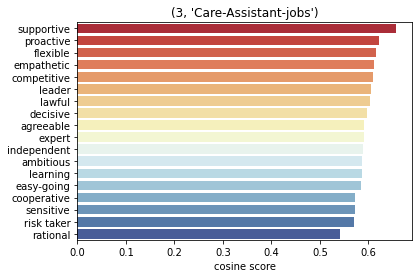

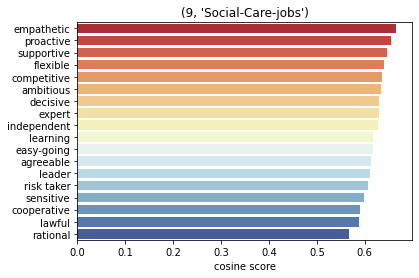

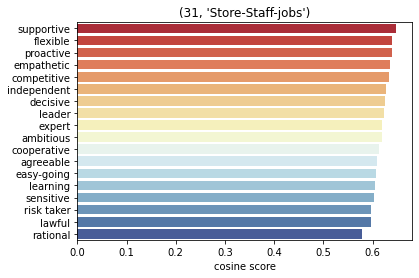

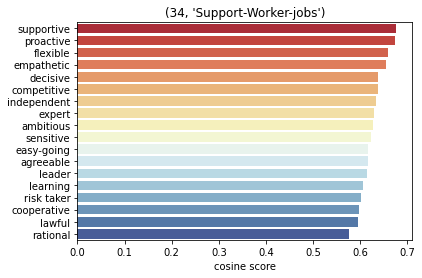

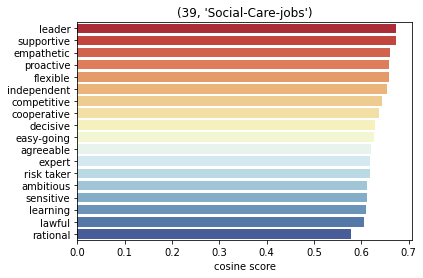

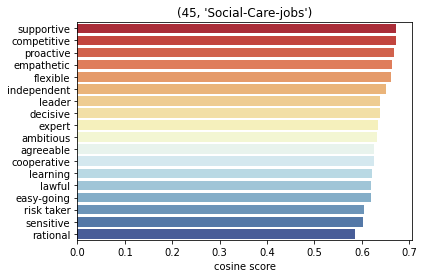

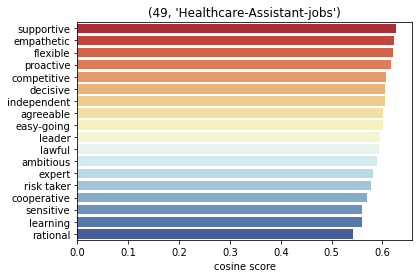

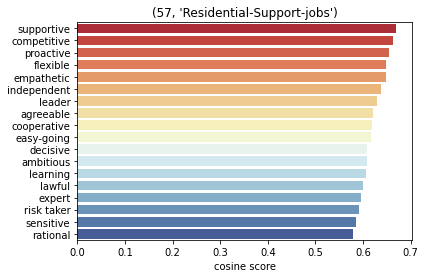

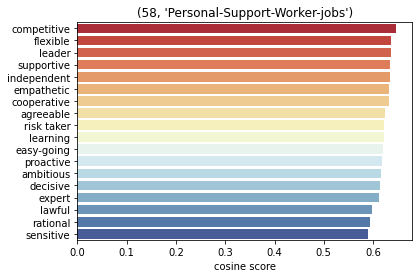

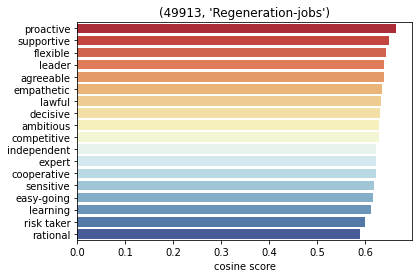

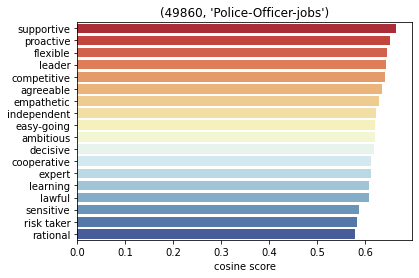

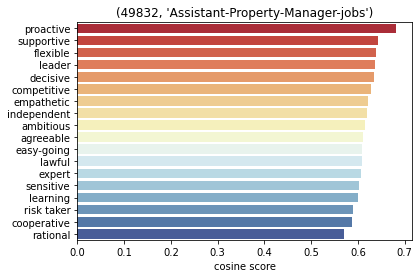

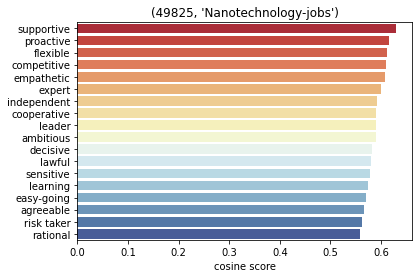

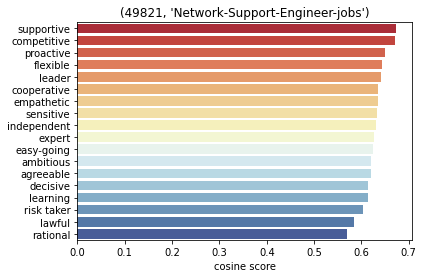

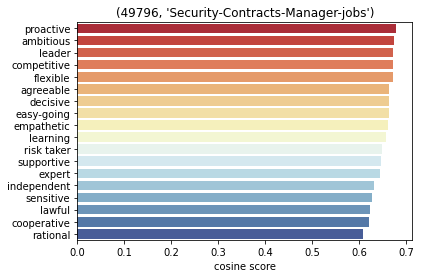

In [26]:
# fig, axes = plt.subplots(nrows = 7, ncols=2)

for key, trait_score in rank_dict.items():
  x = []
  y = []
  for item in trait_score:
    trait, score = item
    x.append(trait)
    y.append(score)
  # for i in range(7):
  #   for j in range(2):
    sns.barplot(y, x, palette = 'RdYlBu')
    plt.xlabel('cosine score')
    plt.title(key)
  plt.show()
# plt.savefig("rank_list.png")

### Visualization trigram embd

In [168]:
def trigram_embd(job_ad, embdder):

  # trait_token_ids, trait_word_embd, trait_embd = embdder(trait)

  trigram_embd_list = []

  for sent in job_ad:
    token_ids, word_embd, sent_embd = embdder(sent)

    sent = sent.translate(remove_punctuation)
    sent = sent.translate(remove_digits)
    # tokens = nltk.word_tokenize(sent)
    tokens = tokenizer.tokenize(sent)
    # tokens = [i.lower() for i in tokens]
    tokens = [i for i in tokens if i not in stopwords.words('english')]
    # trigrams = nltk.trigrams(tokens)
    if len(tokens) > 2:
      trigrams = [tokens[i:i+3] for i in range(len(tokens)-2)]
      for triple in trigrams:
        trigram_token_ids = tokenizer.convert_tokens_to_ids(triple)
        index = []
        for id in trigram_token_ids:
          try: 
            index.append(token_ids[0].tolist().index(id))
          except ValueError:
            pass
        trigram_vec = [word_embd[ind] for ind in index]
      # average the word embd of trigrams
        if len(trigram_vec) >= 2:
          trigram_embd = torch.mean(torch.stack(trigram_vec), dim=0)
          trigram_embd_list.append(trigram_embd.tolist())

  return trigram_embd_list

In [169]:
ad_nums = [3, 9, 31, 34, 39, 45, 49, 57, 58, 49860, 49832, 49825, 49821, 49796]
# traits_1 = ['you are self-reliance', 'capable', 'challenging', 'independent', 'persistent', 'proactive']
# trait = ' '.join(traits_1)
trigram_list = []
for num in ad_nums:
  job_ad = indeed[num]
  job_des = job_ad['sentence']
  trigrams = trigram_embd(job_des, bert_embd)
  trigram_list.append(trigrams)

In [183]:
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [178]:
x=np.vstack(trigram_list)
X_scaled = StandardScaler().fit_transform(x)

In [192]:
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(x)
print(reduced_data_pca.shape)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

(2261, 2)
[0.0523631 0.041495 ]
[458.99827186 408.59801064]


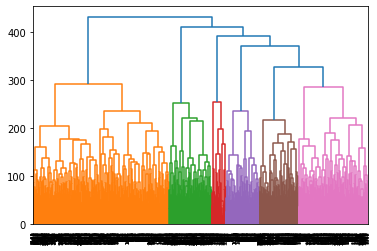

In [191]:
dend = shc.dendrogram(shc.linkage(x, method='ward'))

In [198]:
cluster = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')
cluster.fit_predict(reduced_data_pca)

array([ 2,  2, 10, ...,  8,  4,  7])

Text(0.5, 1.0, 'PCA')

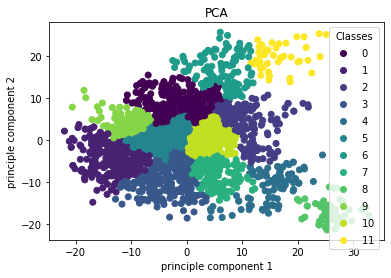

In [199]:
# plt.figure(figsize=(10, 7))
fig, ax = plt.subplots()
scatter = ax.scatter(reduced_data_pca[:,0], reduced_data_pca[:,1], c=cluster.labels_) #cmap='rainbow'
legendClass = ax.legend(*scatter.legend_elements(prop='colors'), loc = 'best', title='Classes')
plt.xlabel('principle component 1')
plt.ylabel('principle component 2')
plt.title('PCA')

In [201]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)

In [188]:
tsne.kl_divergence_

1.2545241117477417

Text(0.5, 1.0, 't-SNE')

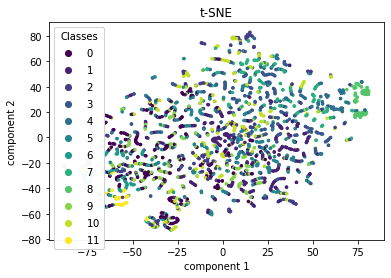

In [200]:
fig, ax = plt.subplots()
scatter = ax.scatter(x_tsne[:,0], x_tsne[:,1], c=cluster.labels_, s=6)
legendClass = ax.legend(*scatter.legend_elements(prop='colors'), loc = 'best', title='Classes')
ax.add_artist(legendClass)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('t-SNE')

### Sentence Transformer & Trigrams

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
# traits
traits_1 = ['self-reliance', 'capable', 'challenging', 'independent', 'persistent', 'proactive']

In [ ]:
# 100 examples in the indeed
job_ads = [ job['sentence']  for job in indeed[:100]]

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def cos_simi(job_ad, trait):

  score_dict = dict()
  trait_embd = model.encode(' '.join(trait))
  trait_embd = torch.Tensor(trait_embd)

  for sent in job_ad:
    sent = sent.translate(remove_punctuation)
    tokens = nltk.word_tokenize(sent)
    tokens = [i.lower() for i in tokens]
    tokens = [i for i in tokens if i not in stopwords.words('english')]
    if len(tokens) > 2:
      trigrams = [tokens[i:i+3] for i in range(len(tokens)-2)]
      # trigrams = nltk.trigrams(tokens)
      for triples in list(trigrams):
        triple_text = ' '.join(triples)
        tri_embd = model.encode(triple_text)
        tri_embd = torch.Tensor(tri_embd)
        cos_sim = F.cosine_similarity(tri_embd, trait_embd, dim=0)
        score_dict[triple_text] = cos_sim.item()
  
  sorted_x = sorted(score_dict.items(),key = lambda x:x[1],reverse = True)

  return sorted_x[:5]

In [ ]:
score = cos_simi(job_ad, traits_1)

In [ ]:
score

[('work extremely rewarding', 0.3876437246799469),
 ('activities daily living', 0.33645516633987427),
 ('putting spare time', 0.3263479769229889),
 ('daily living throughout', 0.3210889995098114),
 ('help activities daily', 0.301276296377182)]

In [ ]:
for job_ad in job_ads[:10]:
  score = cos_simi(job_ad, traits_1)
  print(score)

[('24 days left', 0.02316933684051037), ('2 documents available', 0.002926597837358713), ('days left apply', 0.002804041840136051)]
[('towards independent living', 0.49841827154159546), ('actively seek ways', 0.49112796783447266), ('move towards independent', 0.4043741524219513), ('individuals ensure continues', 0.40344229340553284), ('seek ways work', 0.4020736813545227)]
[('seeking highly motivated', 0.4744707942008972), ('take responsibility practical', 0.4224514365196228), ('actively participate prevention', 0.40254834294319153), ('identify personal development', 0.39758971333503723), ('achieve positive effective', 0.38356560468673706)]
[('skills independent person', 0.5205800533294678), ('skills maintain wellbeing', 0.4642127454280853), ('develop skills independent', 0.44137465953826904), ('behavioural needs live', 0.41745156049728394), ('develop skills maintain', 0.39999839663505554)]
[('waking night support', 0.15818876028060913), ('night support worker', 0.0951041728258133), ('